In [215]:
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


import random
from scipy import stats
from scipy.stats import multivariate_normal, bernoulli, beta, norm
from scipy.stats import ks_2samp
from scipy.special import expit as logistic_sigmoid
import statsmodels.formula.api as smf
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import cross_val_score
from sklearn.metrics import balanced_accuracy_score, brier_score_loss, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import KFold

In [216]:
df = pd.read_csv("Data/merged_tk2025_dataset.csv")
df.columns

Index(['gemeente_naam', 'population',
       'age_BEVOLKING_BEVOLKINGSSAMENSTELLING_OP_1_JANUARI_LEEFTIJD_DEMOGRAFISCHE_DRUK_GRIJZE_DRUK_pct',
       'age_BEVOLKING_BEVOLKINGSSAMENSTELLING_OP_1_JANUARI_LEEFTIJD_DEMOGRAFISCHE_DRUK_GROENE_DRUK_pct',
       'age_BEVOLKING_BEVOLKINGSSAMENSTELLING_OP_1_JANUARI_LEEFTIJD_DEMOGRAFISCHE_DRUK_TOTALE_DRUK_pct',
       'age_BEVOLKING_BEVOLKINGSSAMENSTELLING_OP_1_JANUARI_LEEFTIJD_LEEFTIJDSGROEPEN_10_TOT_15_JAAR_AANTAL_count',
       'age_BEVOLKING_BEVOLKINGSSAMENSTELLING_OP_1_JANUARI_LEEFTIJD_LEEFTIJDSGROEPEN_15_TOT_20_JAAR_AANTAL_count',
       'age_BEVOLKING_BEVOLKINGSSAMENSTELLING_OP_1_JANUARI_LEEFTIJD_LEEFTIJDSGROEPEN_20_TOT_25_JAAR_AANTAL_count',
       'age_BEVOLKING_BEVOLKINGSSAMENSTELLING_OP_1_JANUARI_LEEFTIJD_LEEFTIJDSGROEPEN_25_TOT_45_JAAR_AANTAL_count',
       'age_BEVOLKING_BEVOLKINGSSAMENSTELLING_OP_1_JANUARI_LEEFTIJD_LEEFTIJDSGROEPEN_45_TOT_65_JAAR_AANTAL_count',
       'age_BEVOLKING_BEVOLKINGSSAMENSTELLING_OP_1_JANUARI_LEEFTIJD_LEEF

Convert gender count to percentage

In [217]:
df["women_share"] = (df["women_count"] / (df["men_count"] + df["women_count"])) * 100
df["men_share"]   = (df["men_count"]   / (df["men_count"] + df["women_count"])) * 100

In [218]:
age_count_cols = [c for c in df.columns if c.startswith("age_") and c.endswith("_count")]

age_relatief_cols = [c for c in df.columns if c.startswith("age_") and "LEEFTIJDSGROEPEN_RELATIEF" in c and c.endswith("_pct")]

total_pressure_col = [
    c for c in df.columns
    if c.startswith("age_") and "DEMOGRAFISCHE_DRUK_TOTALE_DRUK" in c and c.endswith("_pct")
]

gender_count_cols = ["men_count", "women_count"]

men_col = ["men_share"]  # keep women_share

df["log_population"] = np.log(df["population"])
cols_to_drop = age_count_cols + age_relatief_cols + total_pressure_col + gender_count_cols + men_col + ["avg_income_household"] + ["num_households"] + ["population"]
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

In [219]:
df.rename(columns={'age_BEVOLKING_BEVOLKINGSSAMENSTELLING_OP_1_JANUARI_LEEFTIJD_DEMOGRAFISCHE_DRUK_GRIJZE_DRUK_pct': 'grijze_druk_pct', 
                   'age_BEVOLKING_BEVOLKINGSSAMENSTELLING_OP_1_JANUARI_LEEFTIJD_DEMOGRAFISCHE_DRUK_GROENE_DRUK_pct': 'groene_druk_pct'}, inplace=True)

In [220]:
#only 5 missing values in total
df.dropna(inplace=True)

In [221]:
econ_target_columns = [col for col in df.columns if col.startswith("econ_") and col.endswith("_share_pct")]
migration_target_columns = [col for col in df.columns if col.startswith("mig_") and col.endswith("_share_pct")]
votes_columns = [col for col in df.columns if col.endswith("_share_pct")]

Economics regressions

In [222]:
def fit_ols_for_target(df, y_col, X_with_const):
    y = pd.to_numeric(df[y_col], errors="coerce")
    data = pd.concat([y.rename("y"), X_with_const], axis=1).dropna()
    y_clean = data["y"]
    X_clean = data.drop(columns=["y"])

    model = sm.OLS(y_clean, X_clean).fit()
    return model

def plot_coef_posteriors(model, n_sims=1000, drop_const=True, max_cols=3, title=None):
    params = model.params
    cov = model.cov_params()

    if drop_const and "const" in params.index:
        params = params.drop("const")
        cov = cov.loc[params.index, params.index]

    coeff_samples = np.random.multivariate_normal(params.values, cov.values, size=n_sims)
    parameter_names = list(params.index)
    n_params = len(parameter_names)

    n_cols = min(max_cols, n_params)
    n_rows = (n_params + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4.5), constrained_layout=True)
    axes_flat = np.array(axes).reshape(-1)

    for i, name in enumerate(parameter_names):
        mean_val = np.mean(coeff_samples[:, i])
        median_val = np.median(coeff_samples[:, i])
        ci_lower, ci_upper = np.percentile(coeff_samples[:, i], [2.5, 97.5])
        percent_positive = np.mean(coeff_samples[:, i] > 0) * 100

        ax = axes_flat[i]
        ax.hist(coeff_samples[:, i], bins=50, edgecolor="gray", alpha=0.85)
        ax.axvline(median_val, linestyle="-", color="green", label=f"Median: {median_val:.3f}")
        ax.axvline(ci_lower, linestyle="--", color="orange", label=f"95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")
        ax.axvline(ci_upper, linestyle="--", color="orange")
        ax.axvline(0, linestyle="--", color="red")
        ax.set_title(name)
        ax.set_xlabel("Value")
        ax.set_ylabel("Frequency")
        ax.legend(title=f"% > 0: {percent_positive:.1f}%")

    for j in range(i + 1, len(axes_flat)):
        axes_flat[j].set_visible(False)

    if title:
        fig.suptitle(title, y=1.02, fontsize=14)

    plt.show()


MODEL: econ_CENTERLEFT_share_pct
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.382
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     28.26
Date:                Wed, 17 Dec 2025   Prob (F-statistic):           3.31e-30
Time:                        12:24:14   Log-Likelihood:                -855.94
No. Observations:                 328   AIC:                             1728.
Df Residuals:                     320   BIC:                             1758.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

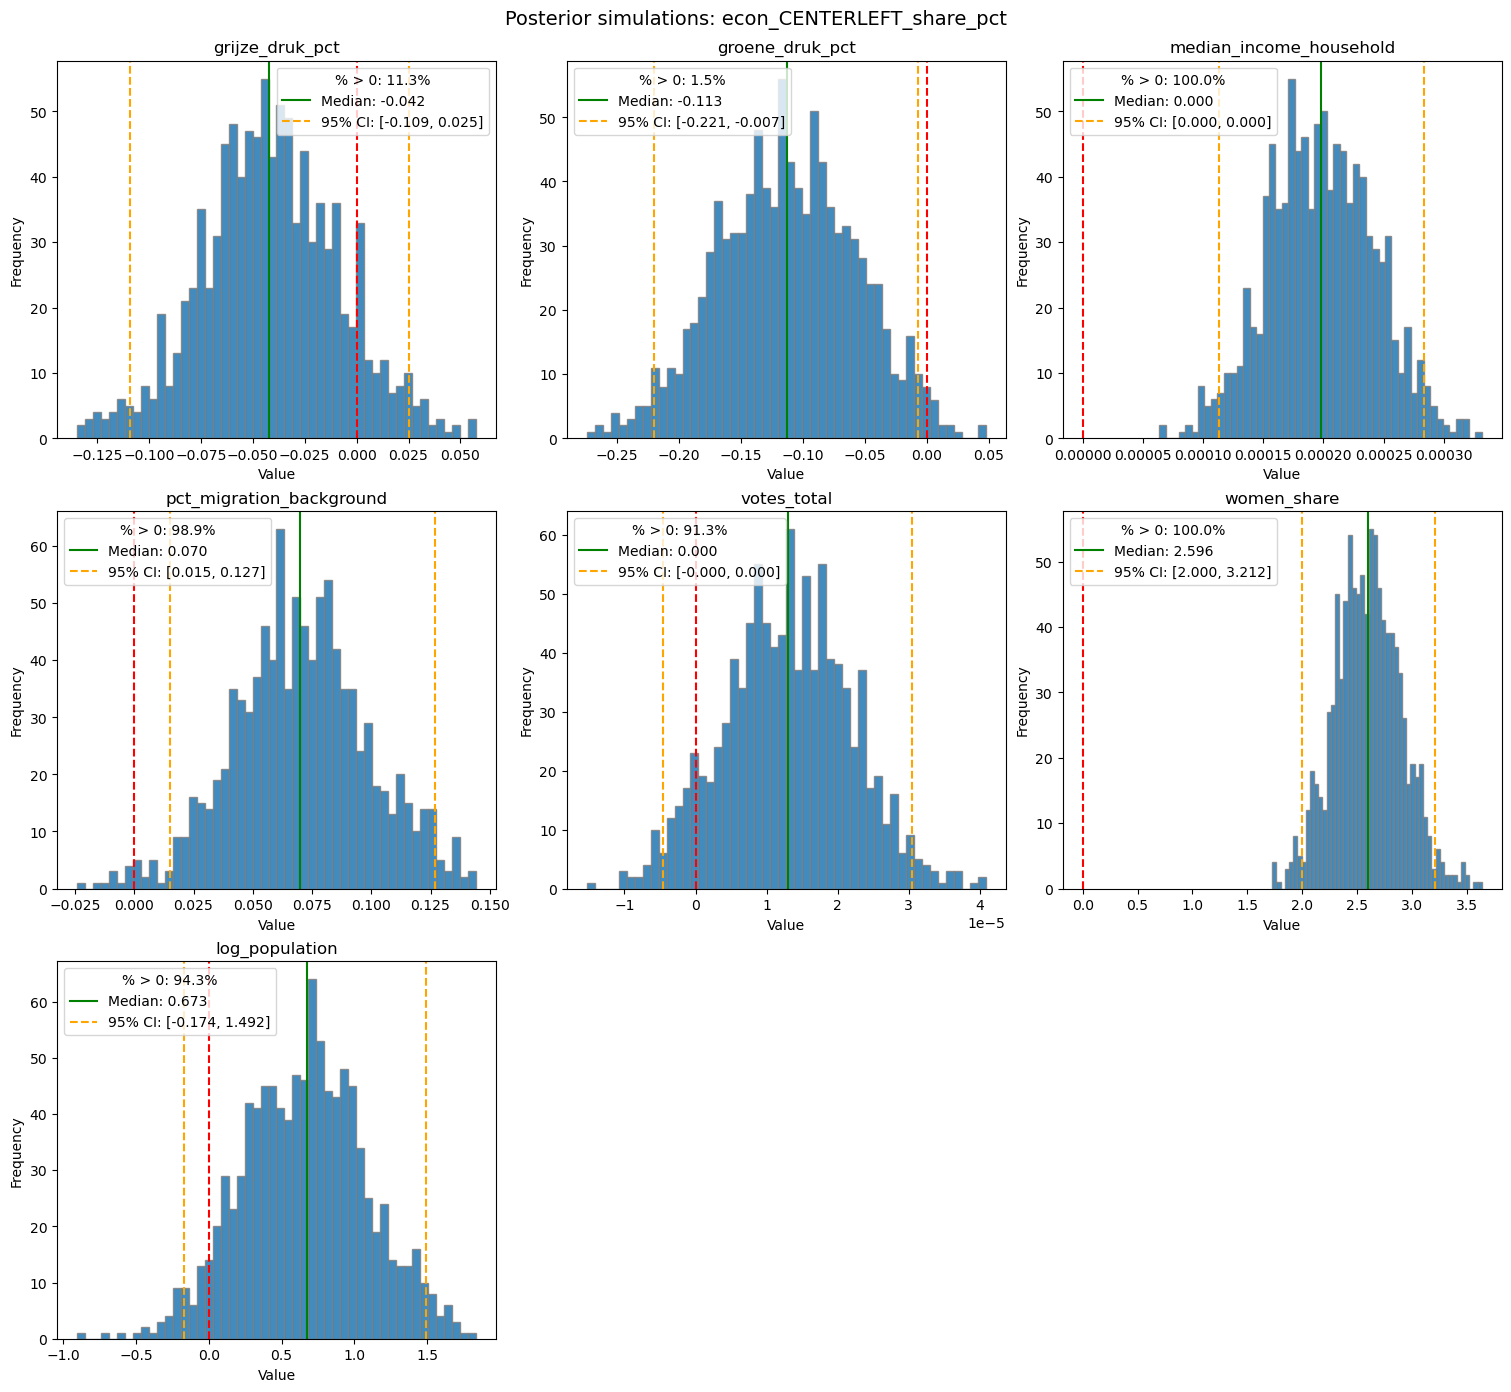


MODEL: econ_CENTERRIGHT_share_pct
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     76.69
Date:                Wed, 17 Dec 2025   Prob (F-statistic):           1.15e-64
Time:                        12:24:15   Log-Likelihood:                -952.07
No. Observations:                 328   AIC:                             1920.
Df Residuals:                     320   BIC:                             1950.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

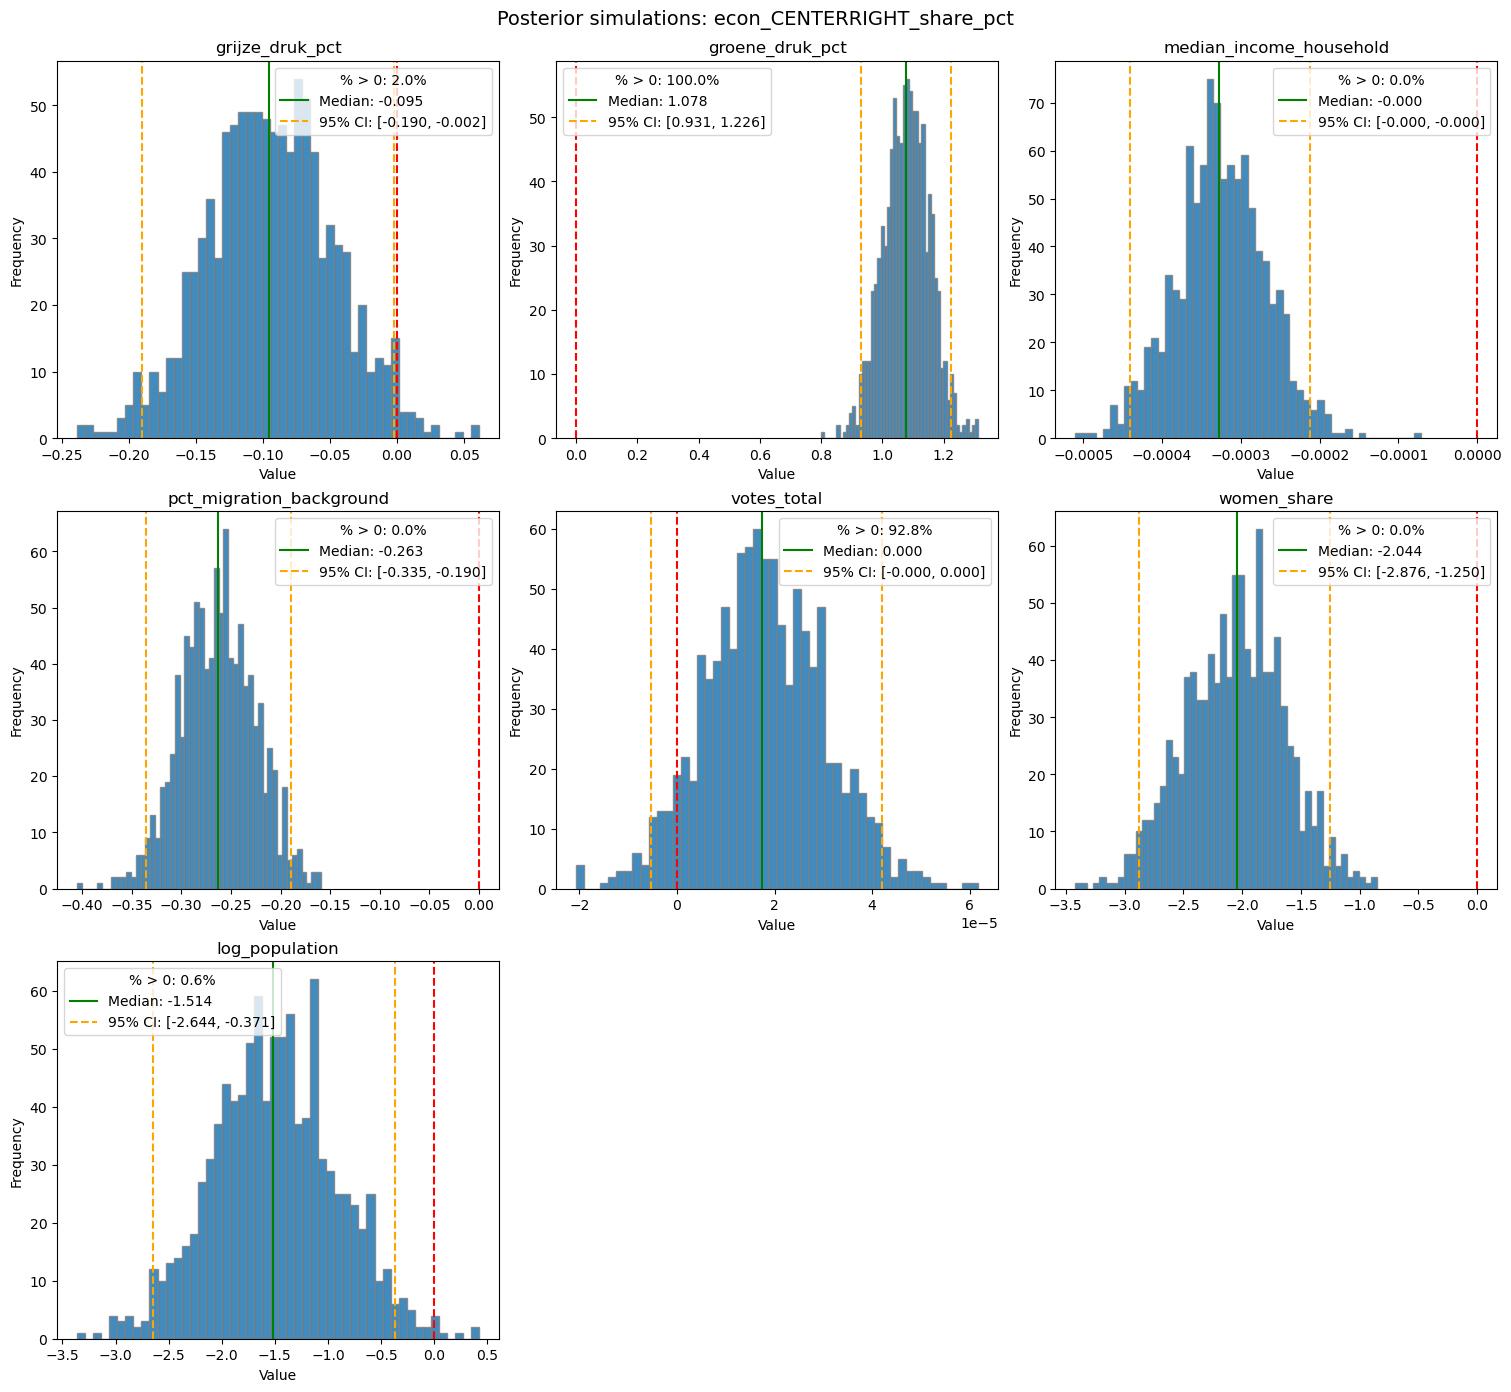


MODEL: econ_LEFT_share_pct
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     73.81
Date:                Wed, 17 Dec 2025   Prob (F-statistic):           5.00e-63
Time:                        12:24:15   Log-Likelihood:                -928.06
No. Observations:                 328   AIC:                             1872.
Df Residuals:                     320   BIC:                             1902.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

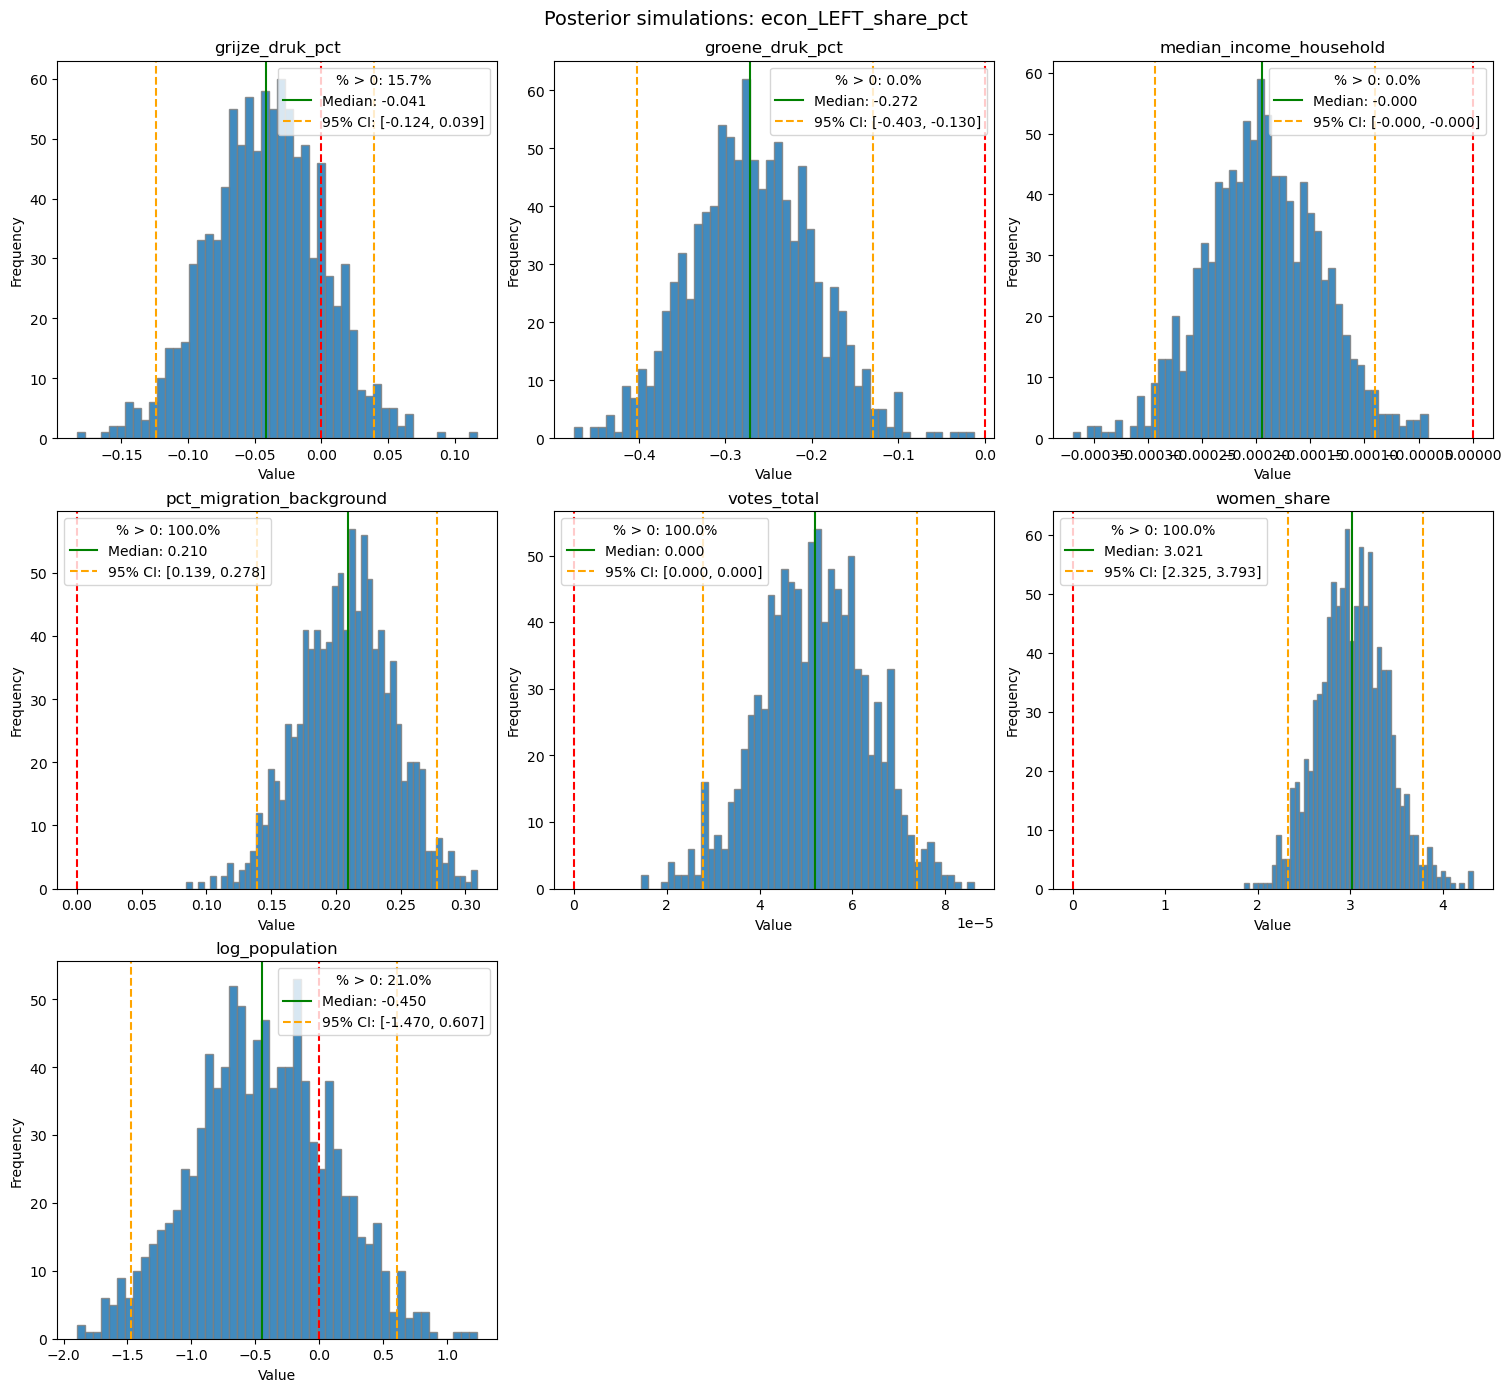


MODEL: econ_RIGHT_share_pct
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     32.09
Date:                Wed, 17 Dec 2025   Prob (F-statistic):           1.26e-33
Time:                        12:24:16   Log-Likelihood:                -1053.9
No. Observations:                 328   AIC:                             2124.
Df Residuals:                     320   BIC:                             2154.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

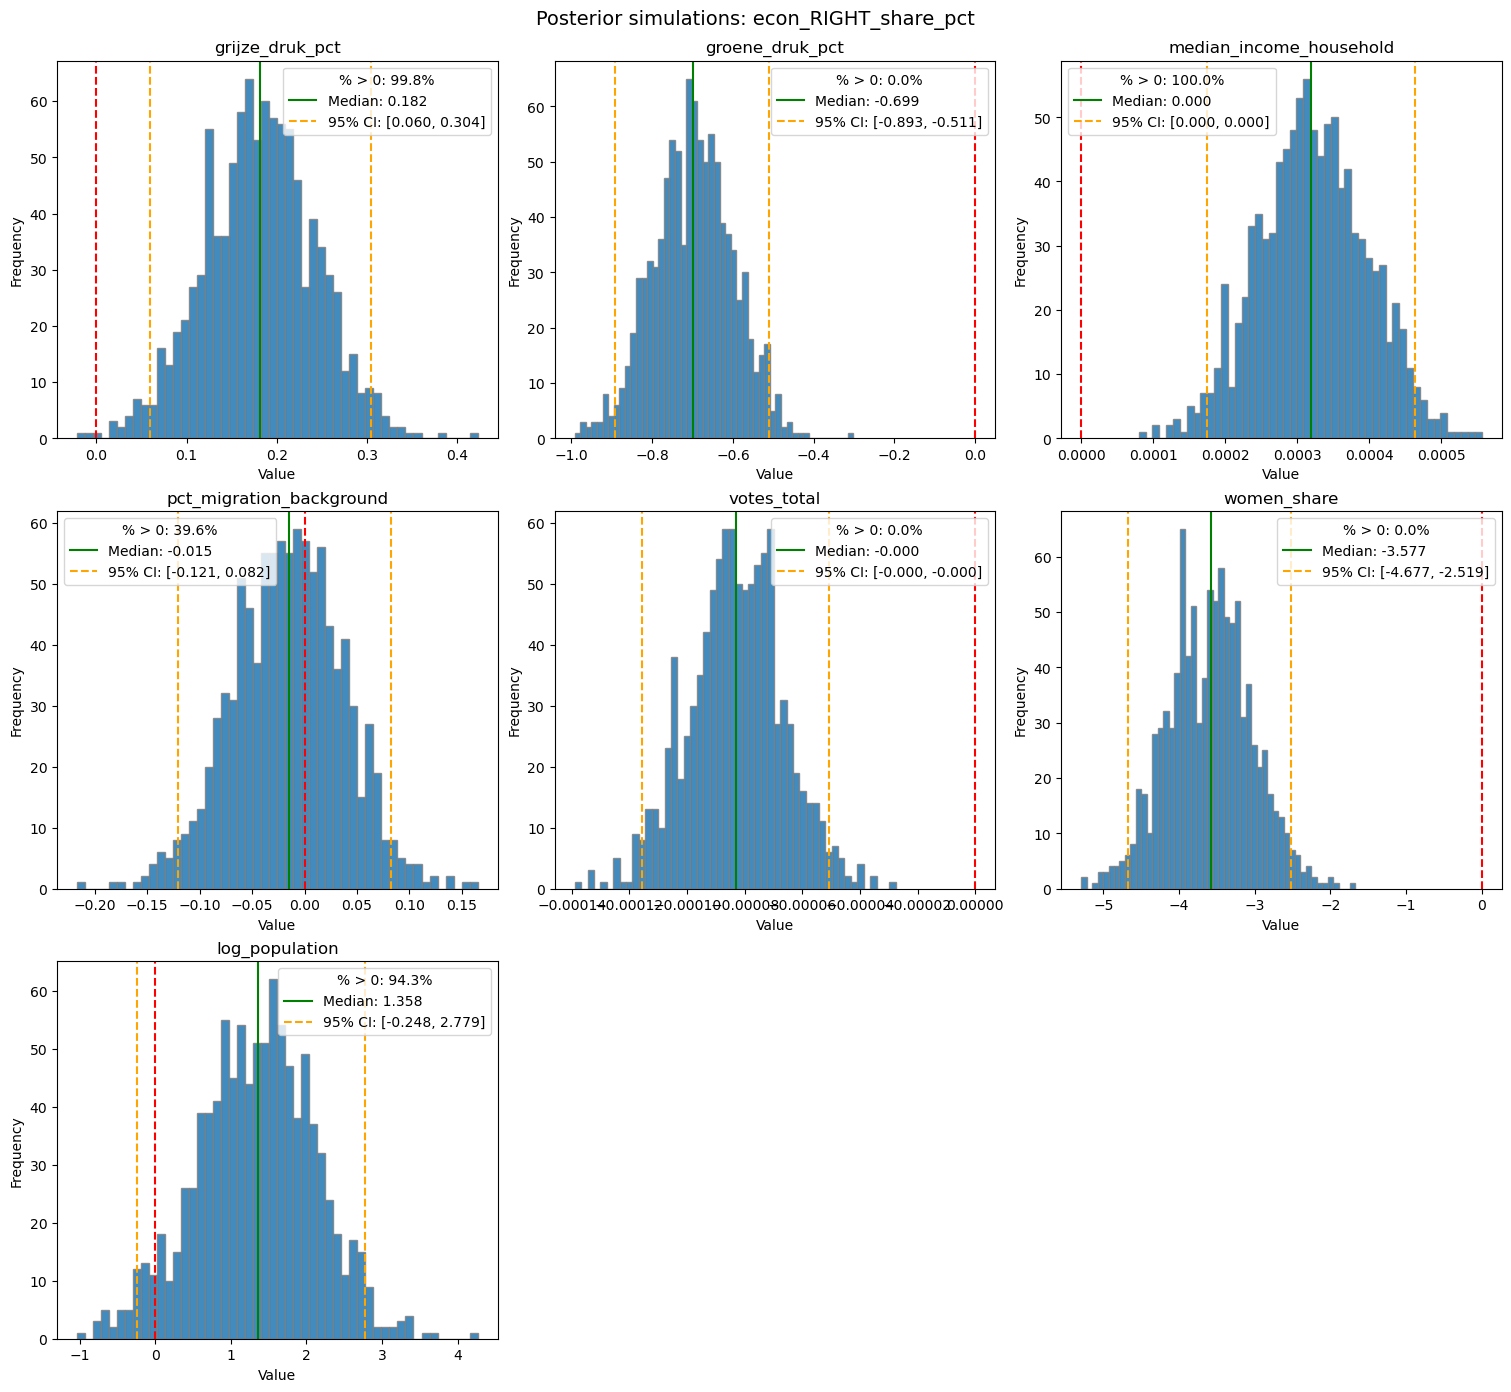


MODEL: mig_CONSERVATIVE_share_pct
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     86.39
Date:                Wed, 17 Dec 2025   Prob (F-statistic):           6.36e-70
Time:                        12:24:16   Log-Likelihood:                -910.63
No. Observations:                 328   AIC:                             1837.
Df Residuals:                     320   BIC:                             1868.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

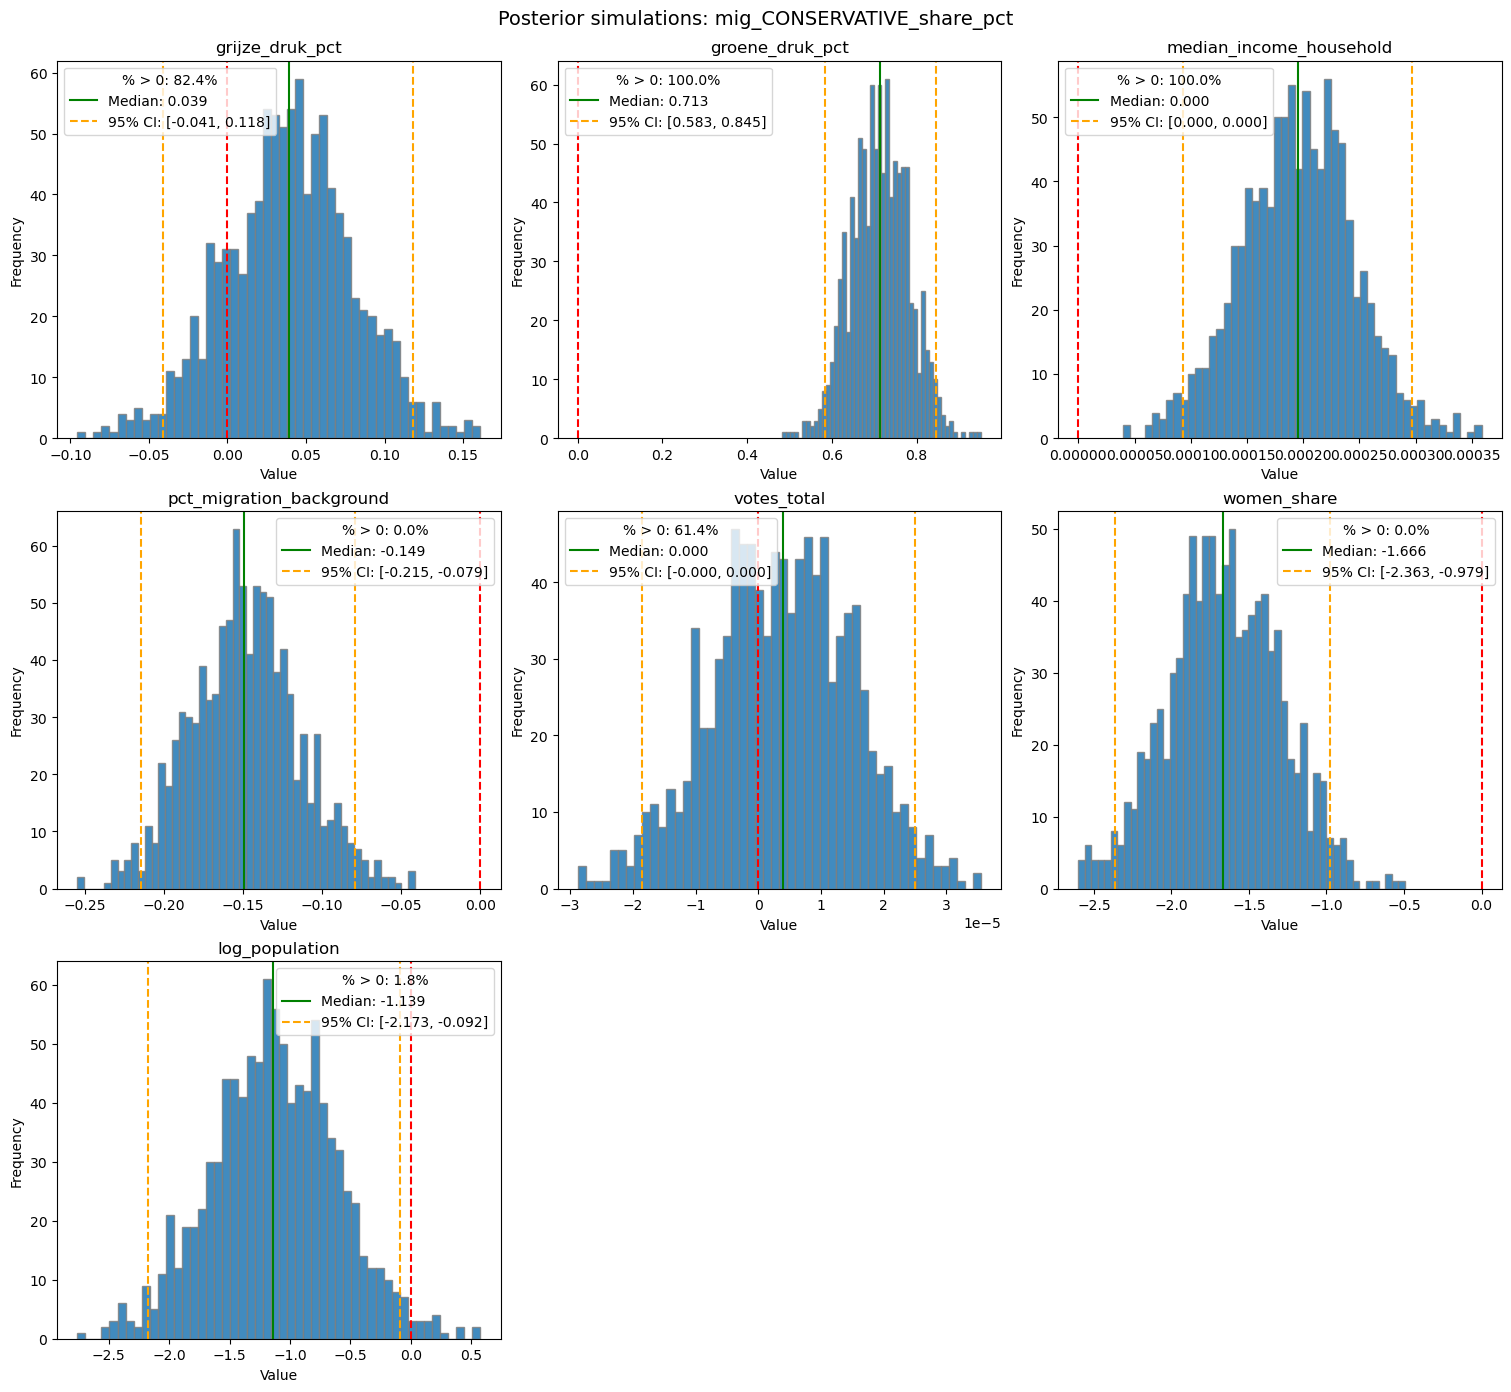


MODEL: mig_EXTREME_CONSERVATIVE_share_pct
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                     30.92
Date:                Wed, 17 Dec 2025   Prob (F-statistic):           1.32e-32
Time:                        12:24:17   Log-Likelihood:                -1034.5
No. Observations:                 328   AIC:                             2085.
Df Residuals:                     320   BIC:                             2115.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

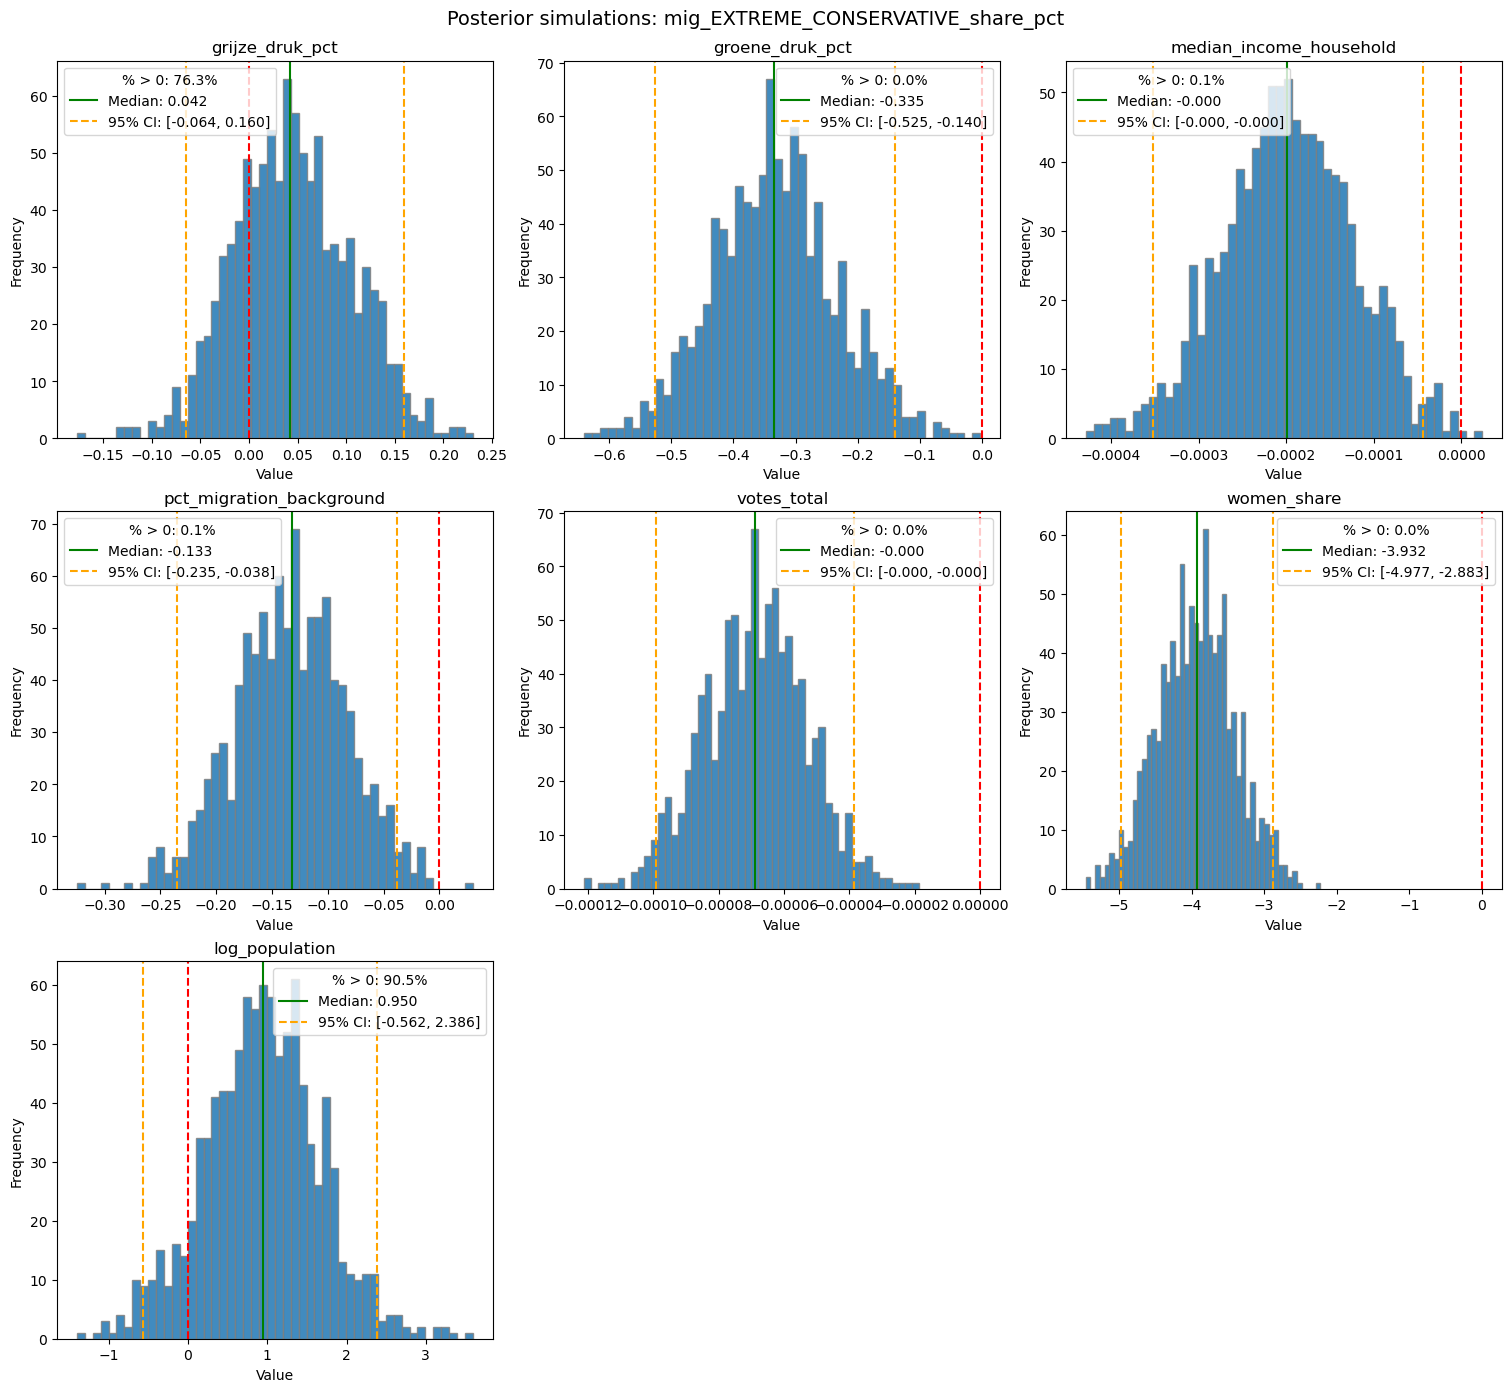


MODEL: mig_EXTREME_PROGRESSIVE_share_pct
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     48.76
Date:                Wed, 17 Dec 2025   Prob (F-statistic):           6.98e-47
Time:                        12:24:17   Log-Likelihood:                -908.57
No. Observations:                 328   AIC:                             1833.
Df Residuals:                     320   BIC:                             1863.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

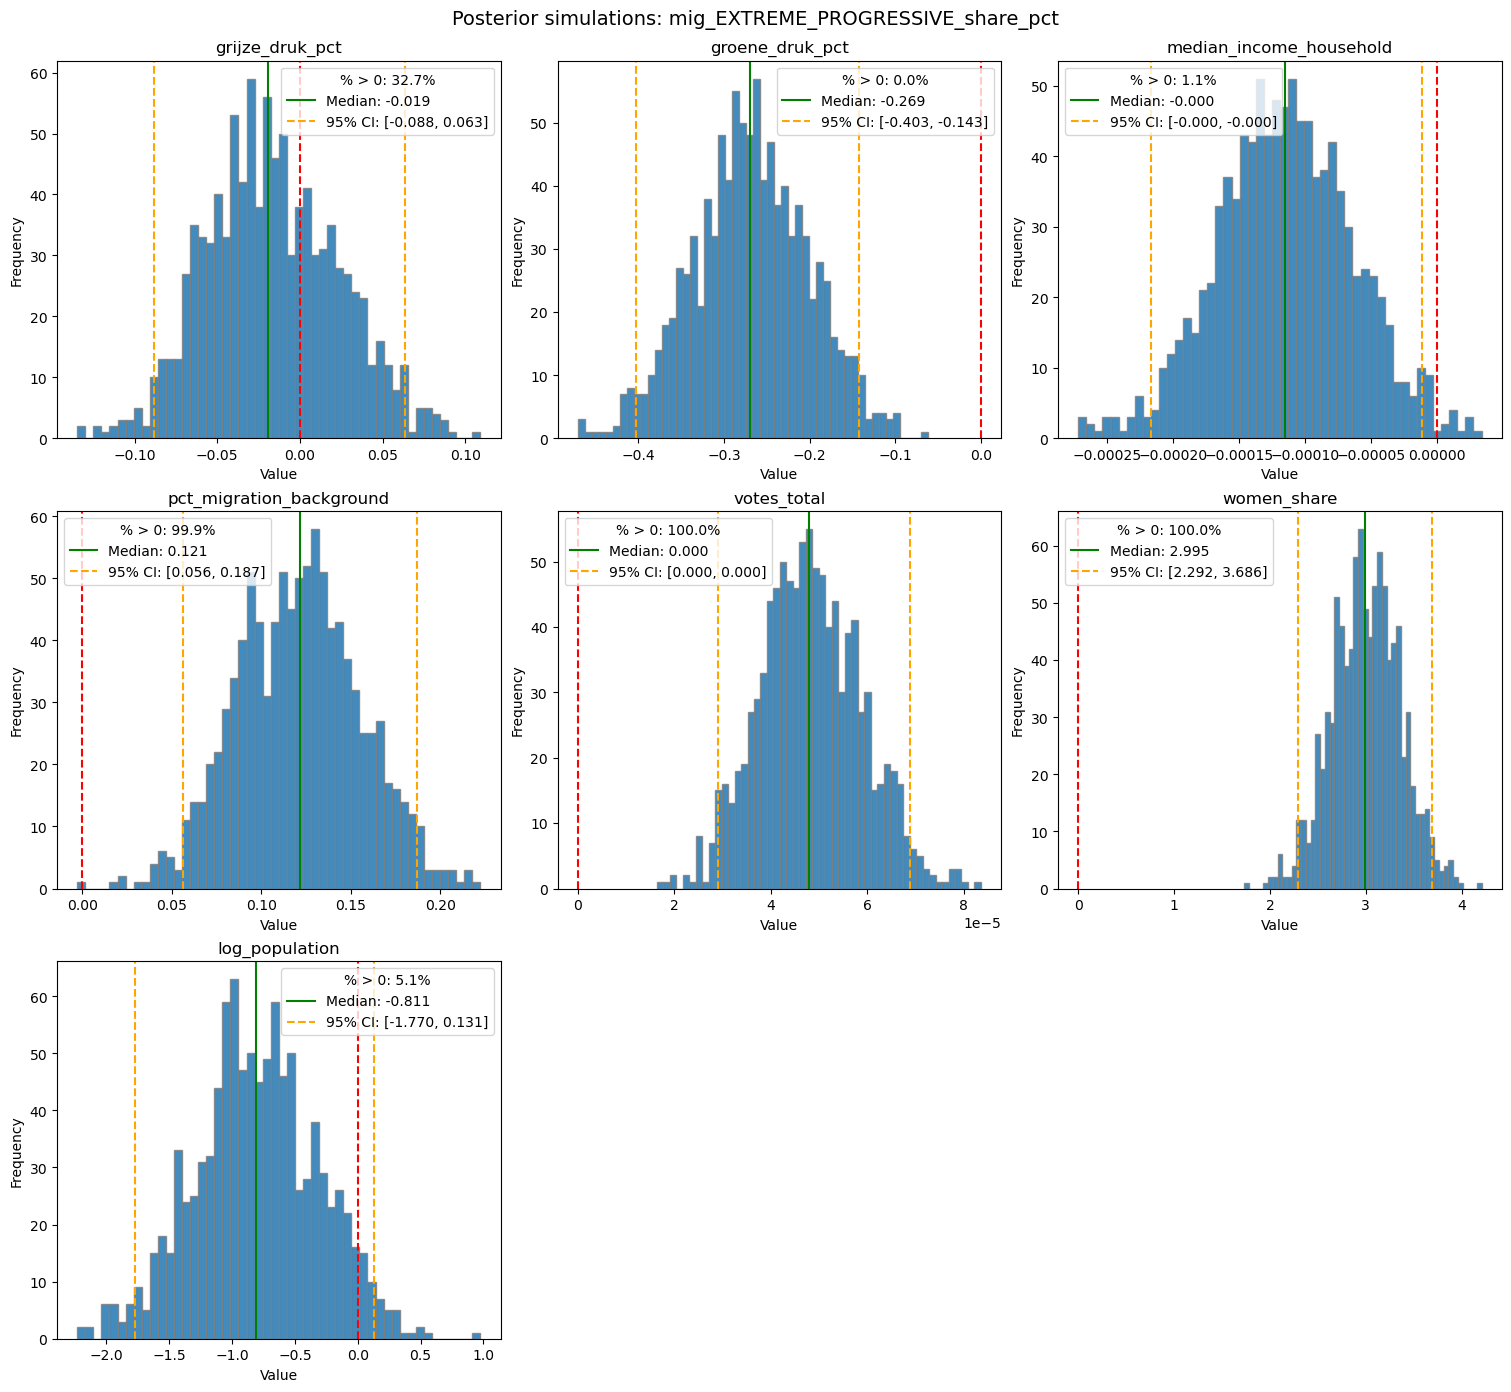


MODEL: mig_PROGRESSIVE_share_pct
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.498
Method:                 Least Squares   F-statistic:                     47.28
Date:                Wed, 17 Dec 2025   Prob (F-statistic):           8.47e-46
Time:                        12:24:18   Log-Likelihood:                -873.37
No. Observations:                 328   AIC:                             1763.
Df Residuals:                     320   BIC:                             1793.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

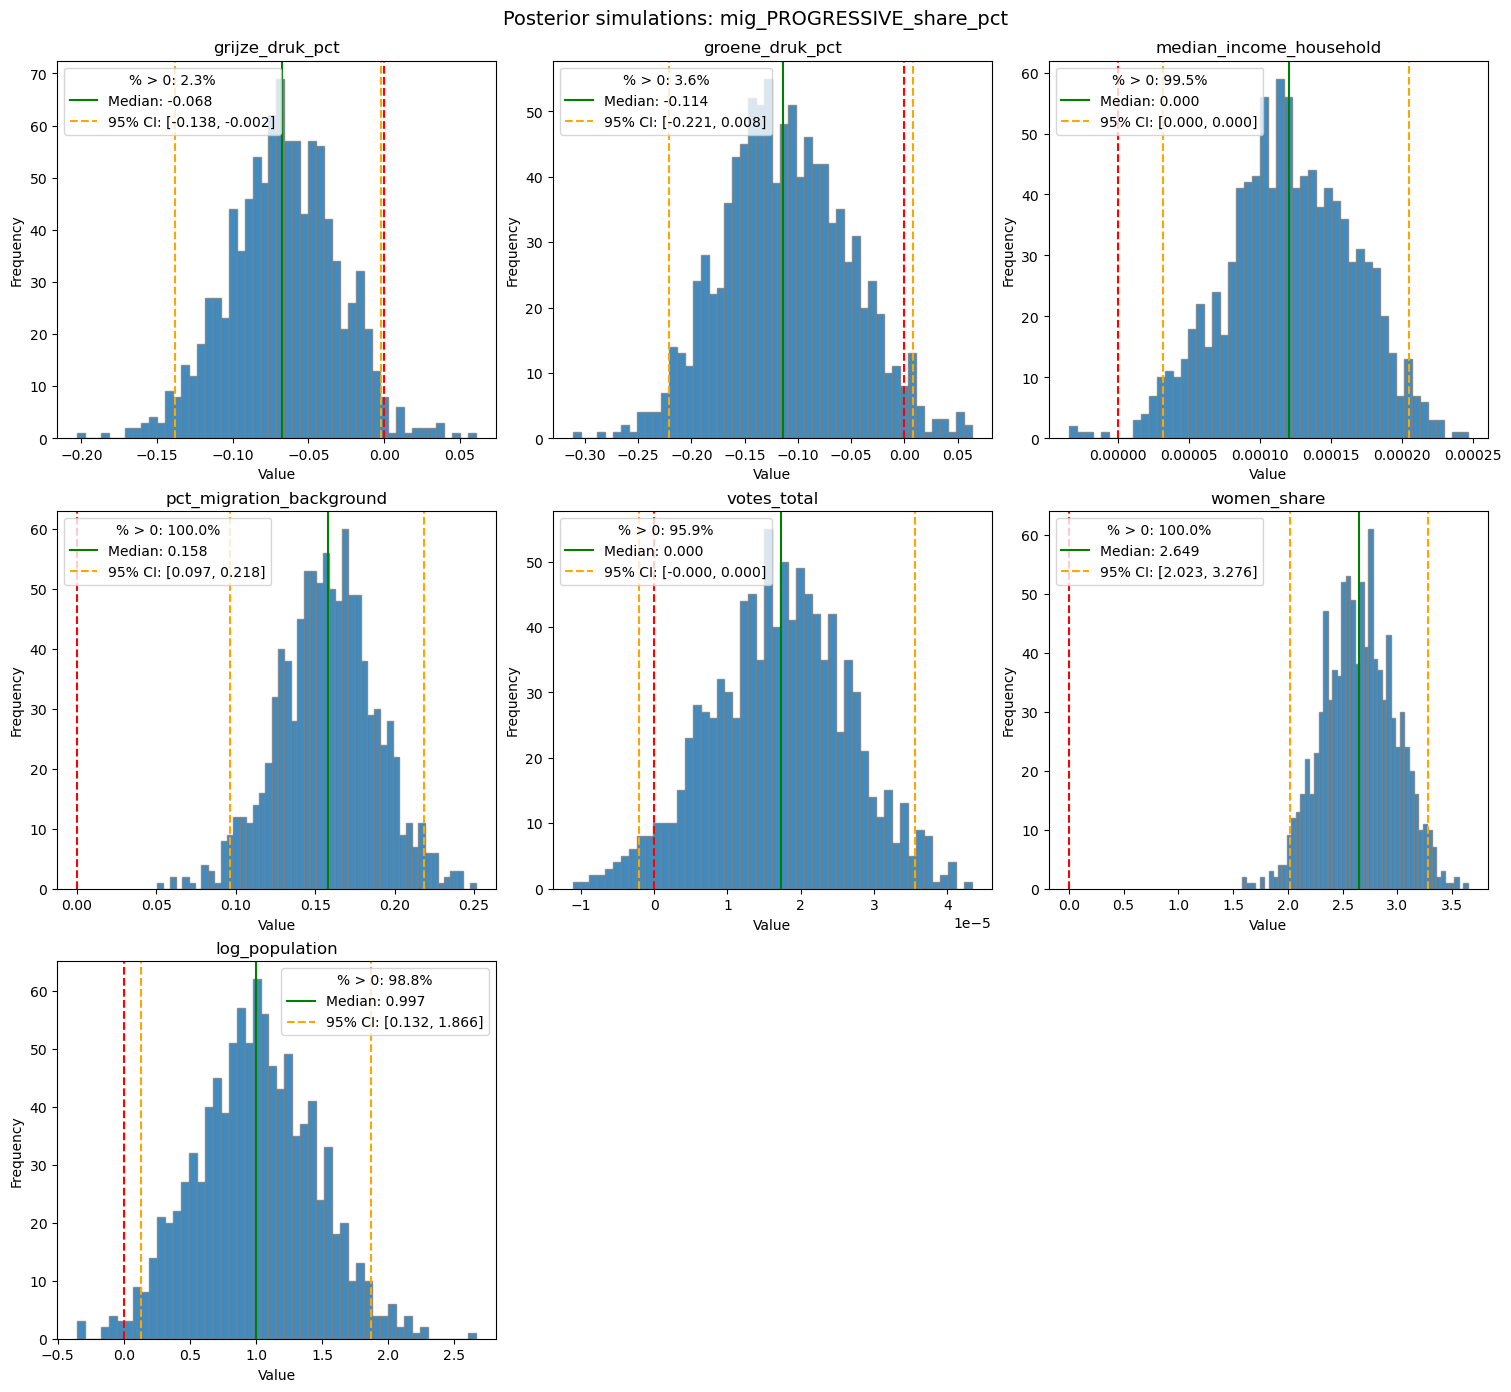

In [223]:
X = df.drop(columns=econ_target_columns + migration_target_columns + votes_columns +["gemeente_naam"]) 
X_with_const = sm.add_constant(X)
all_targets = econ_target_columns + migration_target_columns

models = {}         
summaries = []       

for y_col in all_targets:
    model = fit_ols_for_target(df, y_col, X_with_const)
    models[y_col] = model

    summaries.append({
        "target": y_col,
        "n_obs": int(model.nobs),
        "r2": model.rsquared,
        "adj_r2": model.rsquared_adj,
        "aic": model.aic,
        "bic": model.bic,
    })

summary_df = pd.DataFrame(summaries).sort_values("target")
summary_df

for y_col in all_targets:
    print("\n" + "="*80)
    print("MODEL:", y_col)
    print(models[y_col].summary())

    plot_coef_posteriors(
        models[y_col],
        n_sims=1000,
        drop_const=True,           
        title=f"Posterior simulations: {y_col}"
    )

Evaluation of the models

In [224]:
def fit_predict_evaluate(train_X, train_y, valid_X, valid_y, credibility_pct=95, n_sims=1000):
    model = sm.OLS(train_y, train_X).fit()

    cols = train_X.columns
    beta_hat = model.params.reindex(cols)
    cov_matrix = model.cov_params().reindex(index=cols, columns=cols)

    beta_samples = np.random.multivariate_normal(beta_hat.values, cov_matrix.values, size=n_sims)
    simulated_mus = valid_X.values @ beta_samples.T
    residual_std = np.sqrt(model.scale)
    simulated_ys = simulated_mus + np.random.normal(0, residual_std, simulated_mus.shape)

    monte_carlo_medians = np.median(simulated_ys, axis=1)

    lower_bound = (100 - credibility_pct) / 2
    upper_bound = 100 - lower_bound
    prediction_intervals = np.percentile(simulated_ys, [lower_bound, upper_bound], axis=1).T

    coverage = np.mean(
        (valid_y.values >= prediction_intervals[:, 0]) & (valid_y.values <= prediction_intervals[:, 1])
    ) * 100

    bias = np.mean(monte_carlo_medians - valid_y.values)
    rmse = np.sqrt(mean_squared_error(valid_y.values, monte_carlo_medians))
    correlation = np.corrcoef(valid_y.values, monte_carlo_medians)[0, 1]

    return {
        "bias": bias,
        "rmse": rmse,
        "correlation": correlation,
        "coverage": coverage,
        "predictions": monte_carlo_medians,
        "prediction_intervals": prediction_intervals,
        "simulated_ys": simulated_ys,     
        "valid_y": valid_y.values,  
        "model": model,
    }

def plot_significant_coef_violins(model, n_simulations=1000, p_hi=0.95, p_lo=0.05, drop_const=True, title=None):
    params = model.params
    cov = model.cov_params()

    if drop_const and "const" in params.index:
        params = params.drop("const")
        cov = cov.loc[params.index, params.index]

    simulated_betas = np.random.multivariate_normal(params.values, cov.values, size=n_simulations)
    simulations_df = pd.DataFrame(simulated_betas, columns=params.index)

    long_df = simulations_df.melt(var_name="Coefficient", value_name="Value")

    prob = long_df.groupby("Coefficient")["Value"].apply(lambda x: np.mean(x > 0)).reset_index(name="P(coef>0)")
    keep = prob[(prob["P(coef>0)"] > p_hi) | (prob["P(coef>0)"] < p_lo)]["Coefficient"]

    filtered = long_df[long_df["Coefficient"].isin(keep)]
    if filtered.empty:
        print(title or "Model", "→ no coefficients pass the sign-probability filter.")
        return

    medians = filtered.groupby("Coefficient")["Value"].median().sort_values()
    order = medians.index.tolist()

    plt.figure(figsize=(12, 6))
    sns.violinplot(x="Coefficient", y="Value", data=filtered, order=order)
    plt.axhline(0, linestyle="--")
    plt.xticks(rotation=90)
    plt.xlabel("Coefficient")
    plt.ylabel("Simulated value")

    if title:
        plt.title(title)
    else:
        plt.title(f"Coefficient posterior (filtered): {p_hi}/{p_lo}")

    plt.tight_layout()
    plt.show()

def plot_performance_histograms(score, title=None):
    simulated_ys = score["simulated_ys"]  
    valid_y = score["valid_y"]          

    bias_values = simulated_ys.mean(axis=0) - valid_y.mean()
    rmse_values = np.sqrt(np.mean((simulated_ys - valid_y[:, None]) ** 2, axis=0))
    correlation_values = np.array([
        np.corrcoef(valid_y, simulated_ys[:, i])[0, 1] for i in range(simulated_ys.shape[1])
    ])

    metrics = {"Bias": bias_values, "RMSE": rmse_values, "Correlation": correlation_values}

    fig, axes = plt.subplots(1, 3, figsize=(15, 4.5), constrained_layout=True)
    for ax, (metric_name, values) in zip(axes, metrics.items()):
        median_val = np.median(values)
        ci_lower, ci_upper = np.percentile(values, [2.5, 97.5])

        ax.hist(values, bins=50, alpha=0.85, edgecolor="gray")
        ax.axvline(median_val, color="green", linestyle="-", label=f"Median: {median_val:.3f}")
        ax.axvline(ci_lower, color="orange", linestyle="--", label="95% CI")
        ax.axvline(ci_upper, color="orange", linestyle="--")
        ax.axvline(0, color="red", linestyle="--")
        ax.set_title(f"{metric_name} (Monte Carlo)")
        ax.set_xlabel(metric_name)
        ax.set_ylabel("Frequency")
        ax.legend()

    if title:
        fig.suptitle(title, y=1.05, fontsize=14)

    plt.show()

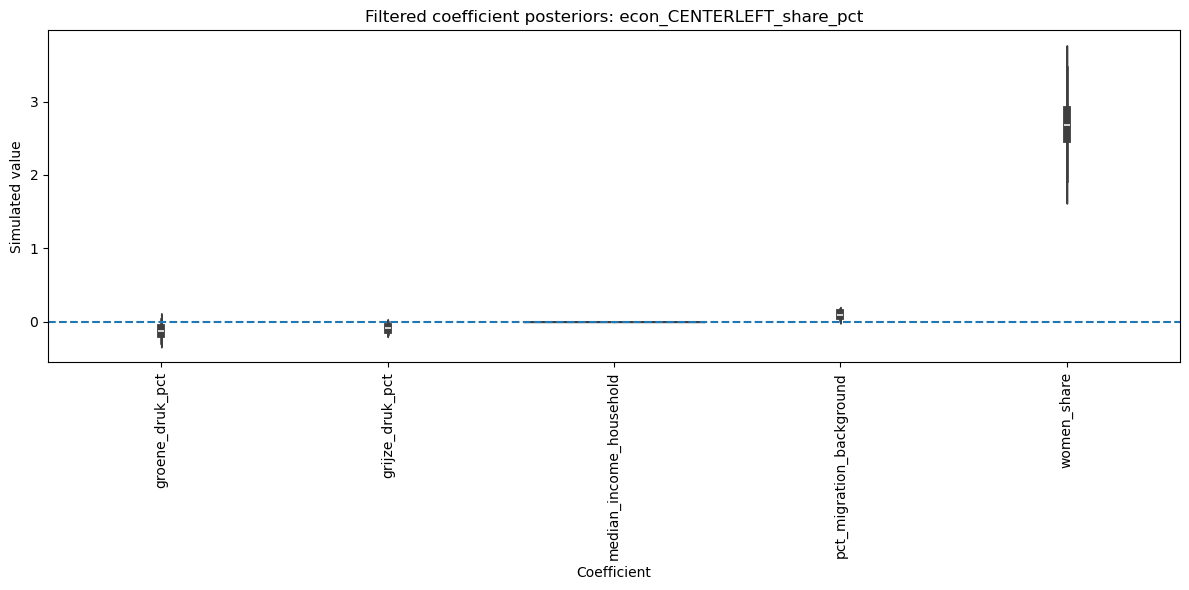

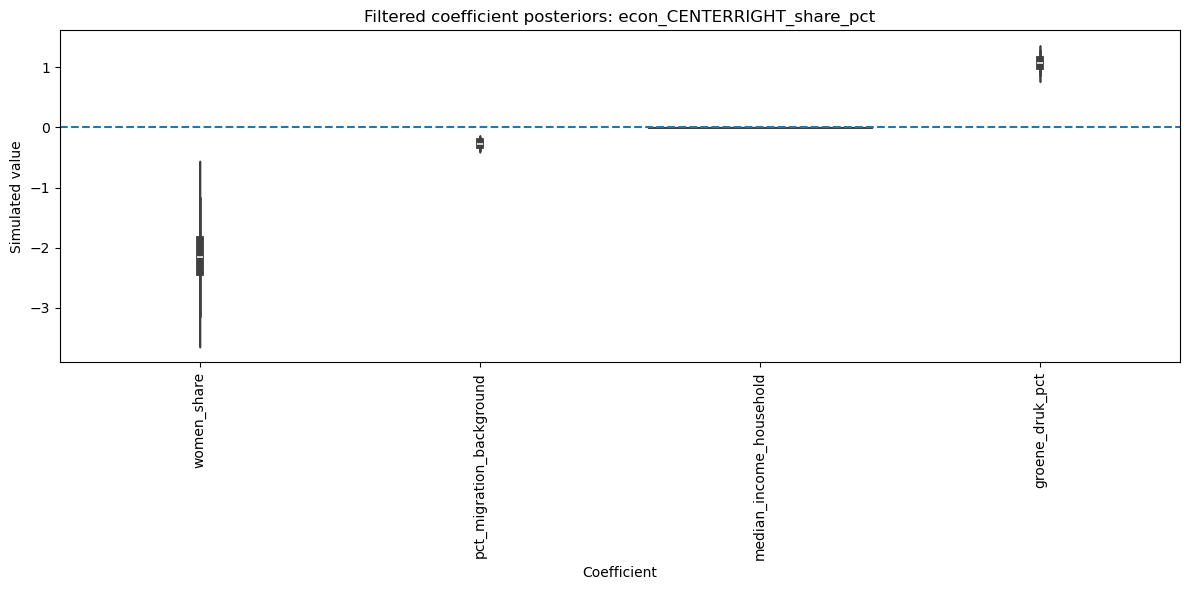

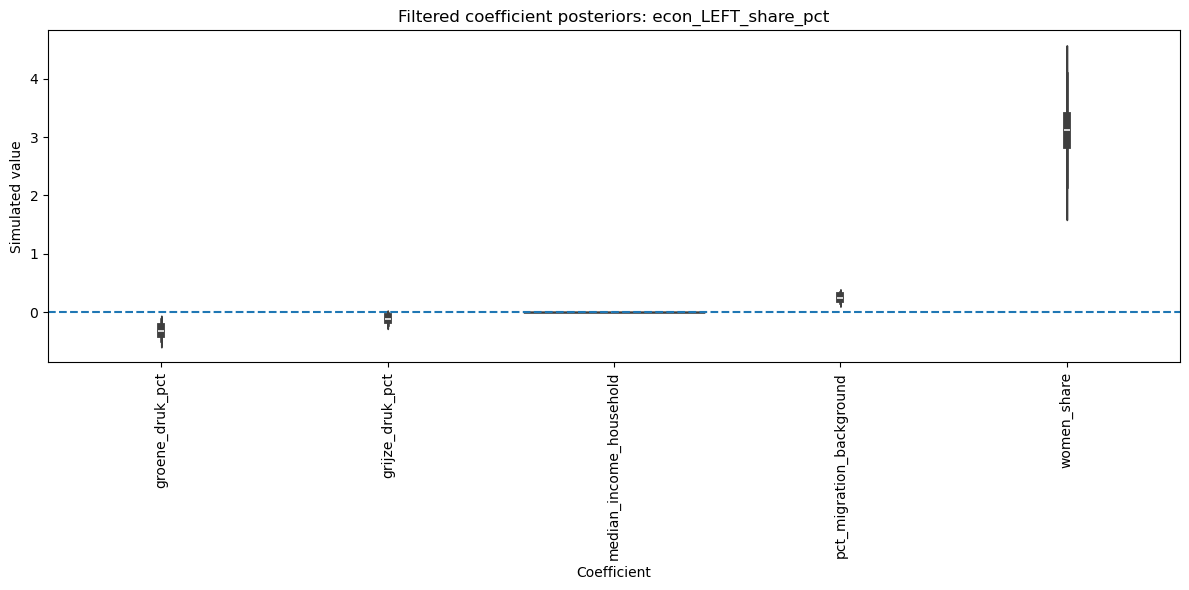

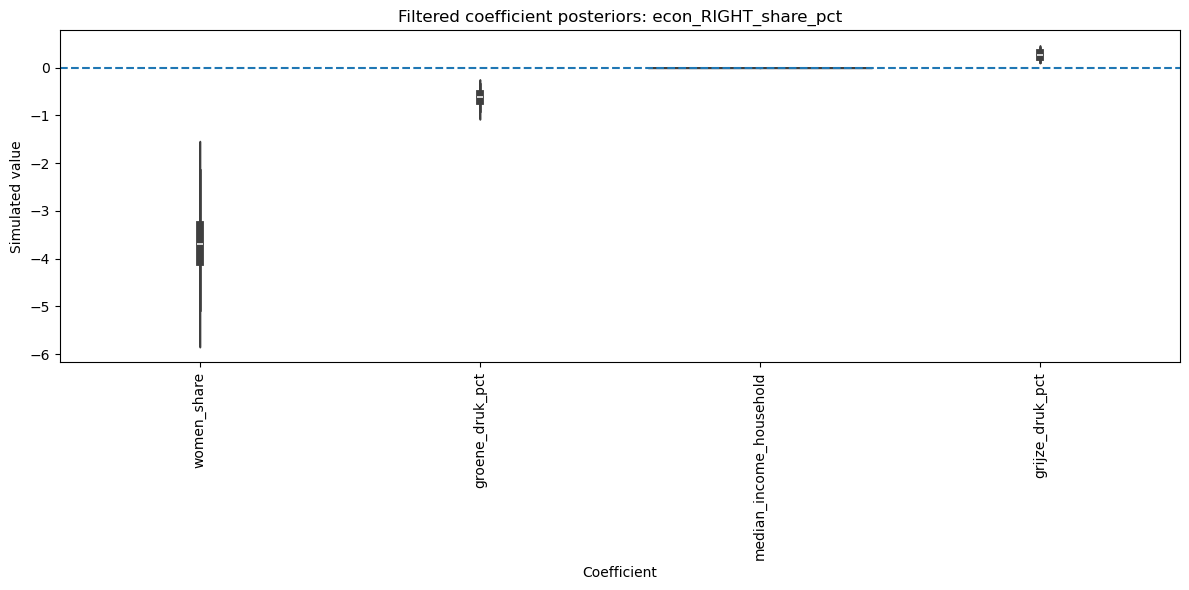

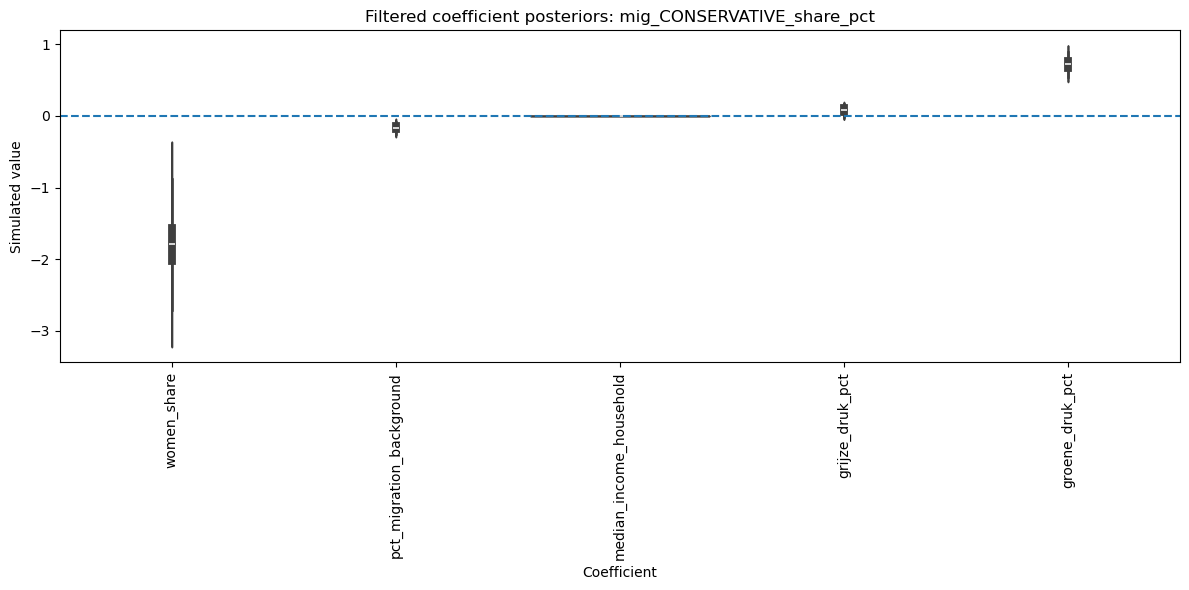

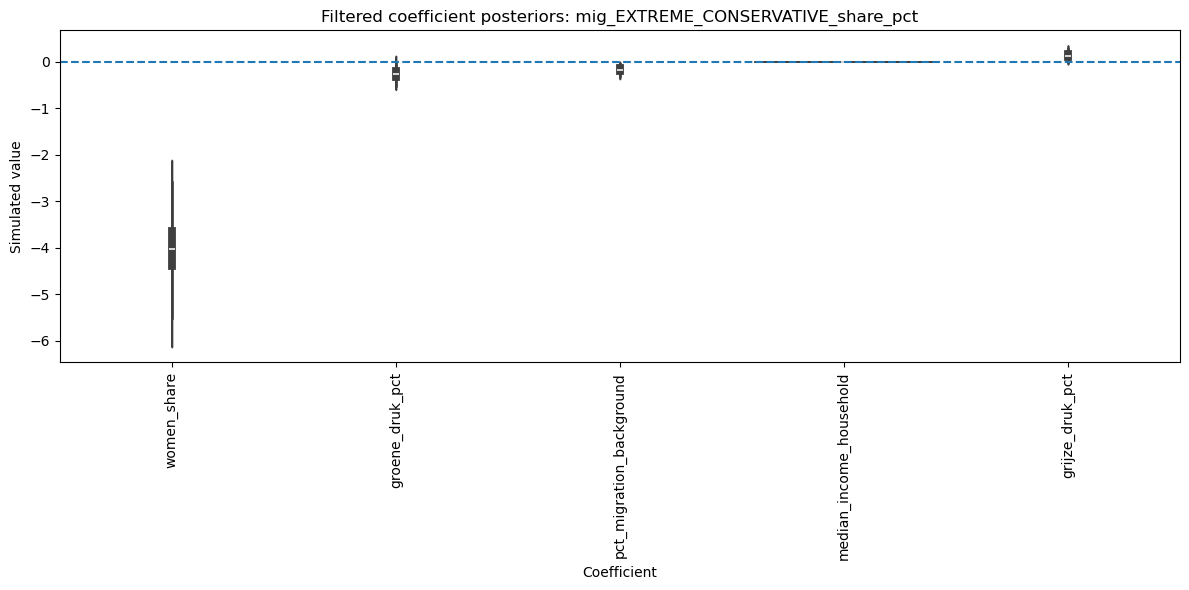

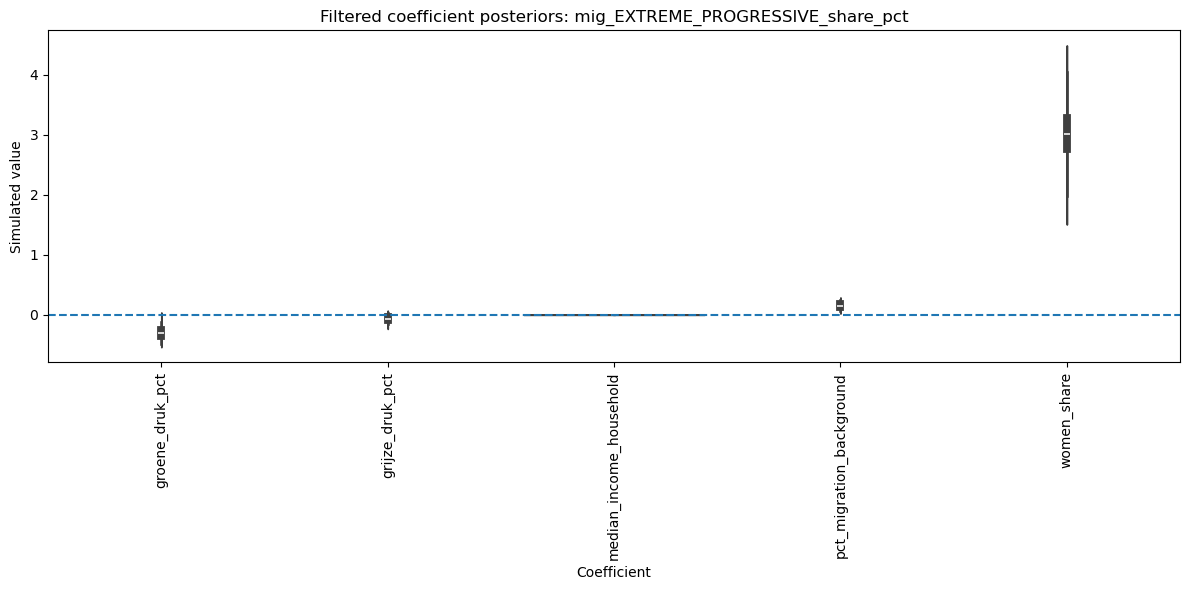

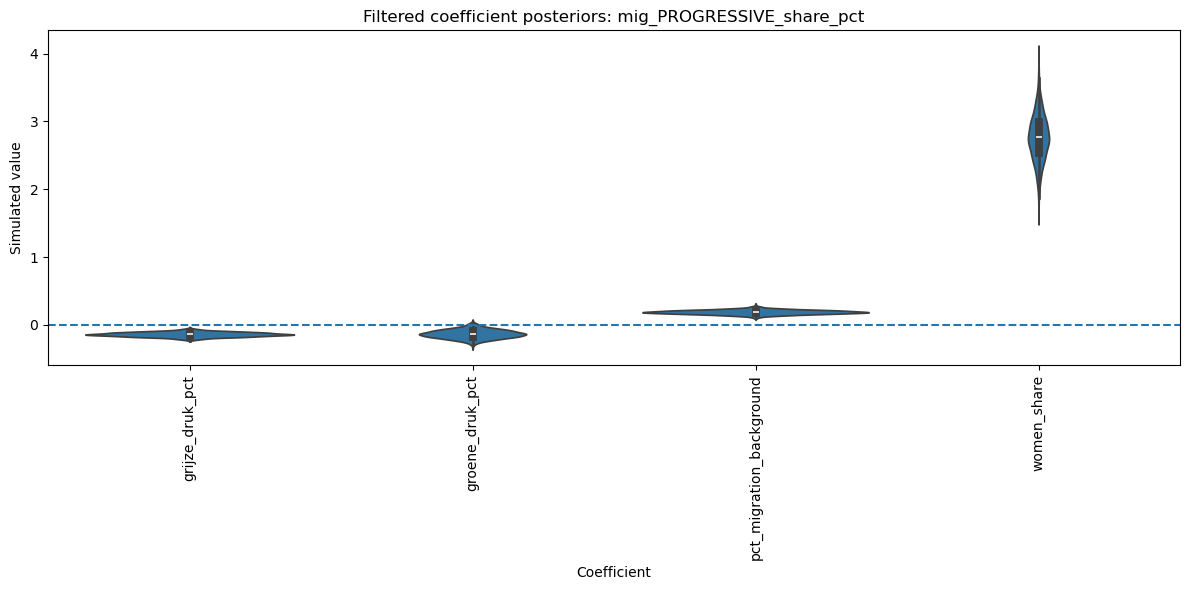

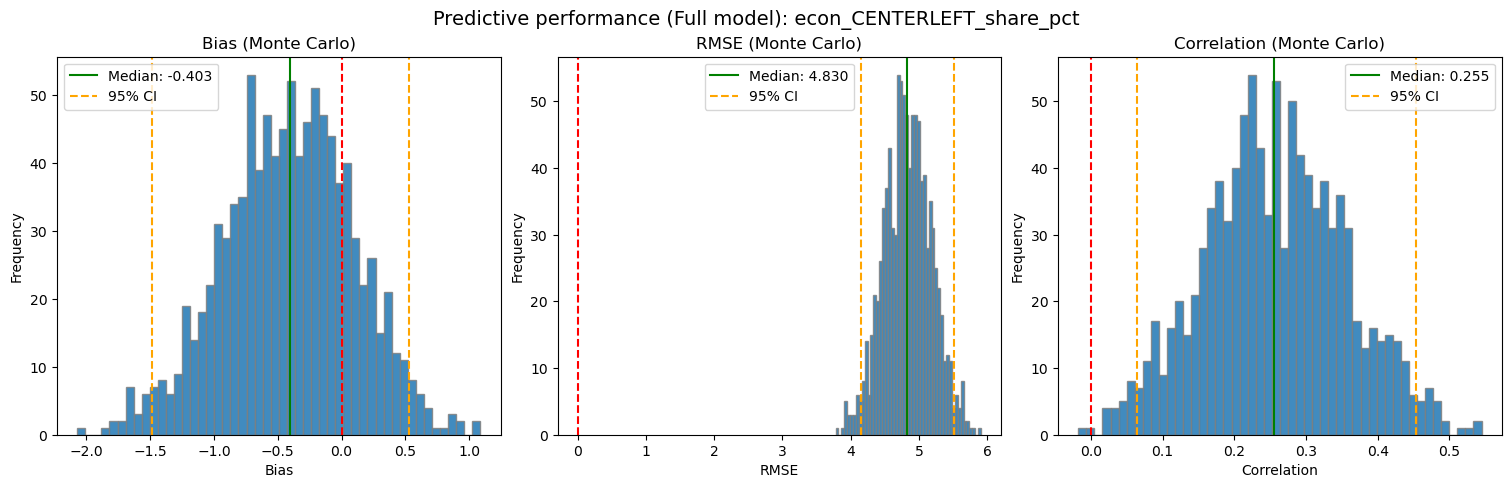

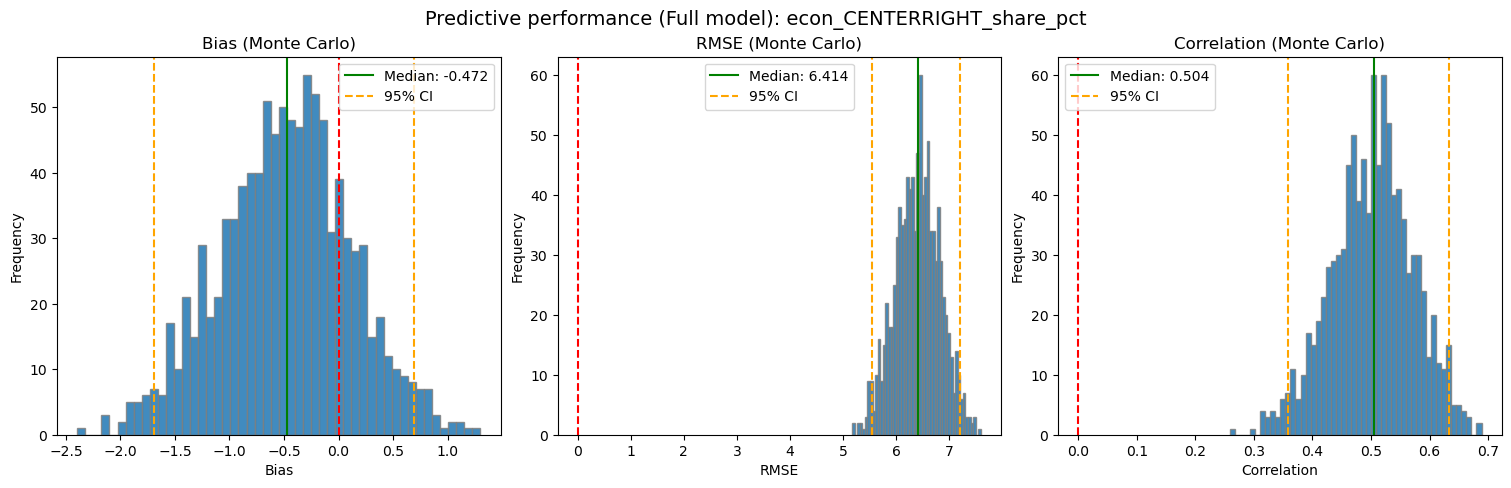

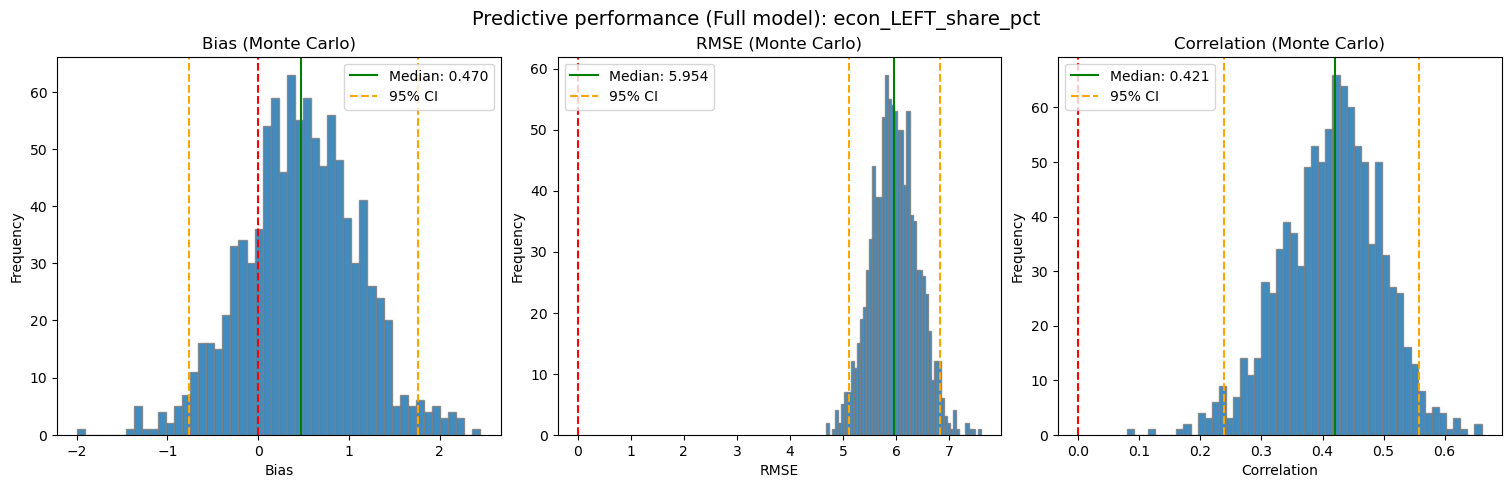

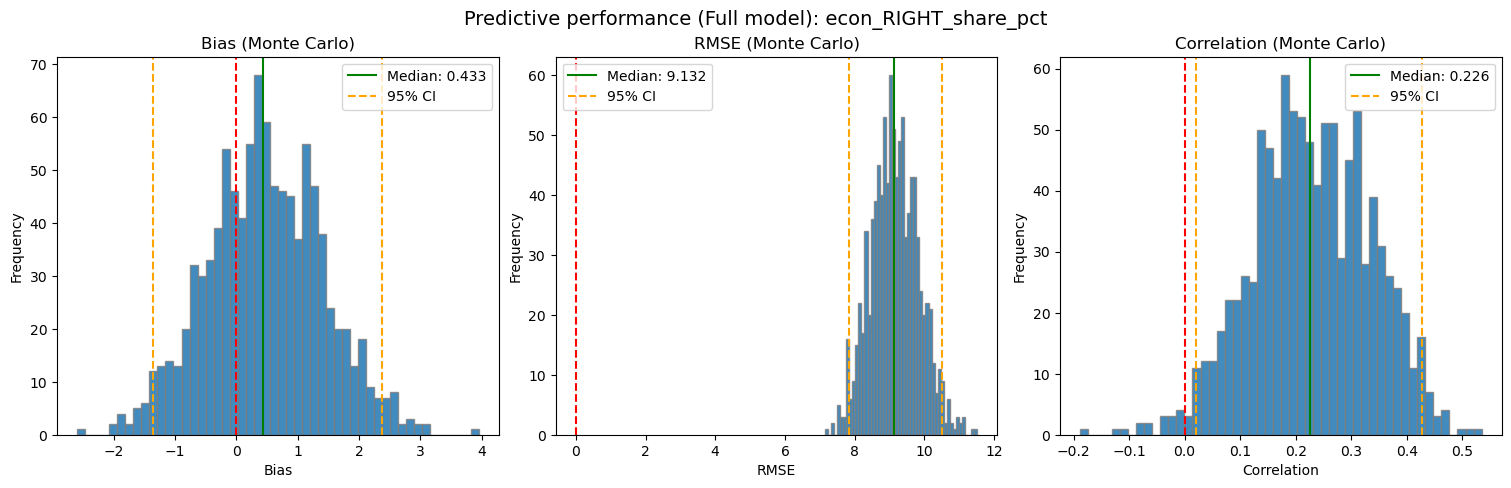

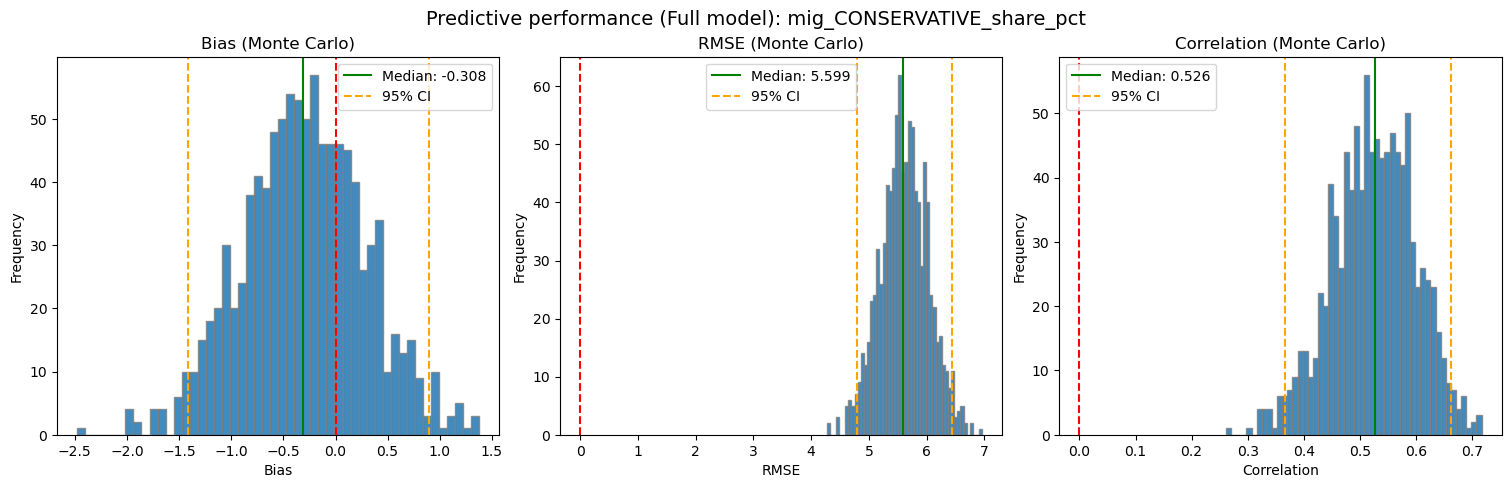

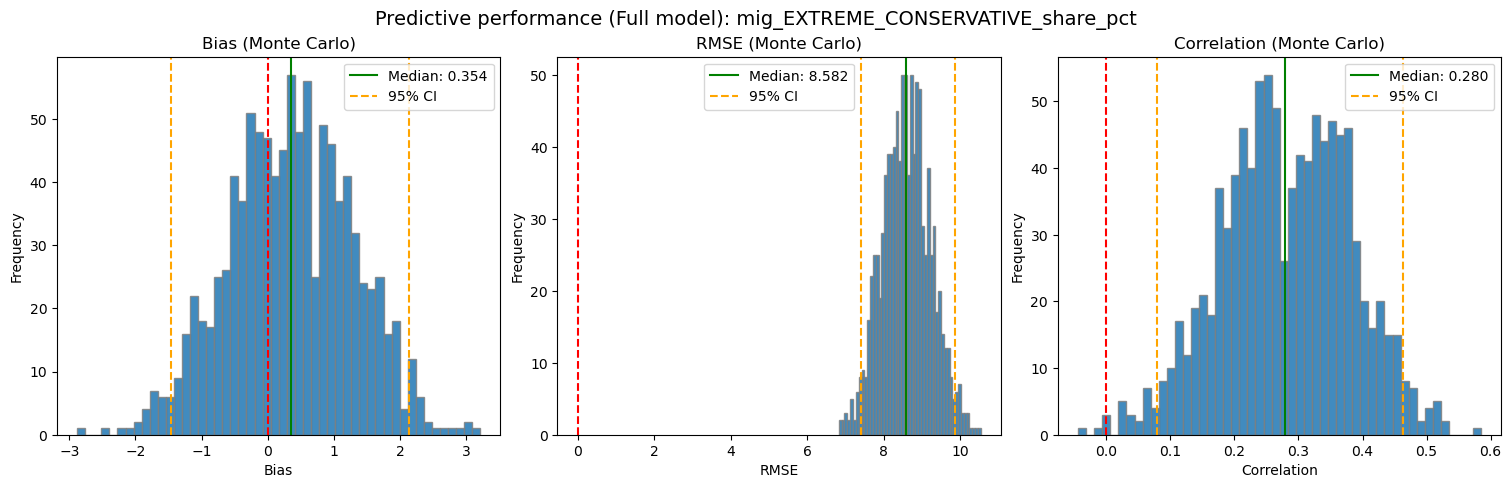

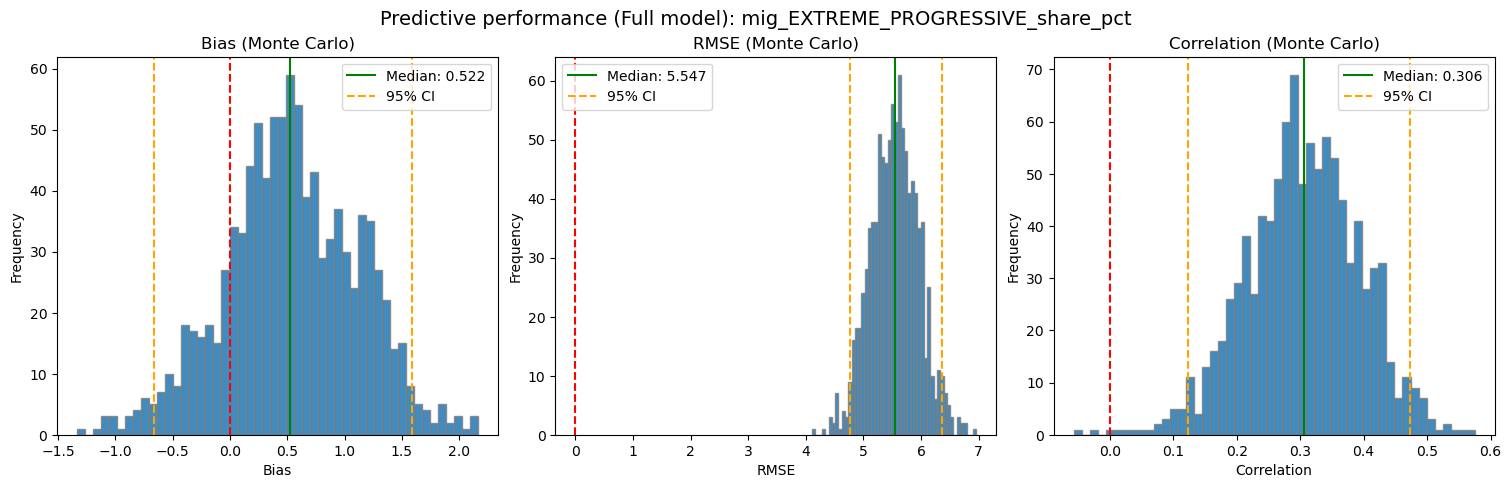

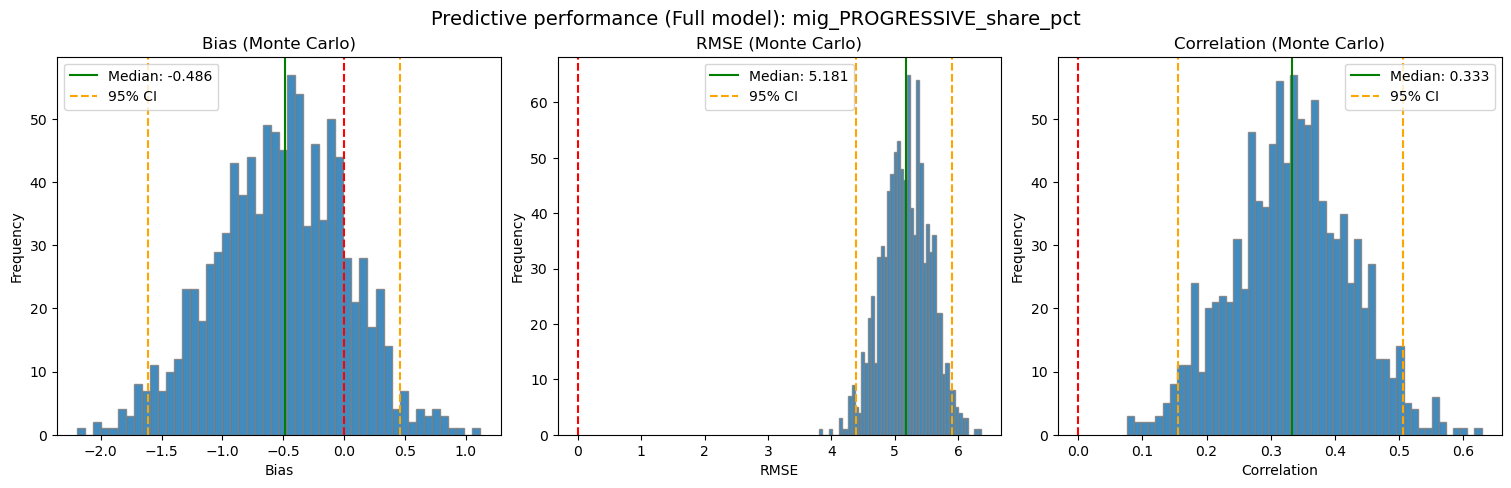

In [226]:
x_cols = [
    "grijze_druk_pct",
    "groene_druk_pct",
    "median_income_household",
    "pct_migration_background",
    "women_share",
]

df = df.copy()

models = {}
eval_full = {}
eval_baselines = {}
rows = []

for y_col in all_targets:
    model_df = df[[y_col] + x_cols].copy()
    for c in model_df.columns:
        model_df[c] = pd.to_numeric(model_df[c], errors="coerce")
    model_df = model_df.dropna()

    train_df, temp_df = train_test_split(model_df, test_size=0.5, random_state=42)
    valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

    X_train = sm.add_constant(train_df[x_cols], has_constant="add")
    y_train = train_df[y_col]
    X_valid = sm.add_constant(valid_df[x_cols], has_constant="add")
    y_valid = valid_df[y_col]

    X0_train = sm.add_constant(pd.DataFrame(index=train_df.index), has_constant="add")
    X0_valid = sm.add_constant(pd.DataFrame(index=valid_df.index), has_constant="add")

    Xs_train = sm.add_constant(train_df[["women_share"]], has_constant="add")
    Xs_valid = sm.add_constant(valid_df[["women_share"]], has_constant="add")

    score_full = fit_predict_evaluate(X_train, y_train, X_valid, y_valid, credibility_pct=95, n_sims=1000)
    score_int  = fit_predict_evaluate(X0_train, y_train, X0_valid, y_valid, credibility_pct=95, n_sims=1000)
    score_sex  = fit_predict_evaluate(Xs_train, y_train, Xs_valid, y_valid, credibility_pct=95, n_sims=1000)

    eval_full[y_col] = score_full
    eval_baselines[y_col] = {"Intercept only": score_int, "Sex only": score_sex}

    model_fullsample = sm.OLS(model_df[y_col], sm.add_constant(model_df[x_cols], has_constant="add")).fit()
    models[y_col] = model_fullsample

    for spec_name, sc in [("Intercept only", score_int), ("Sex only", score_sex), ("Full", score_full)]:
        rows.append({
            "target": y_col,
            "spec": spec_name,
            "bias": sc["bias"],
            "rmse": sc["rmse"],
            "correlation": sc["correlation"],
            "coverage": sc["coverage"],
            "n_train": len(train_df),
            "n_valid": len(valid_df),
        })

eval_table = pd.DataFrame(rows).sort_values(["target", "spec"])
eval_table

for y_col in all_targets:
    plot_significant_coef_violins(
        models[y_col],
        n_simulations=1000,
        p_hi=0.95,
        p_lo=0.05,
        drop_const=True,
        title=f"Filtered coefficient posteriors: {y_col}"
    )
    
for y_col in all_targets:
    plot_performance_histograms(
        eval_full[y_col],
        title=f"Predictive performance (Full model): {y_col}"
    )
